# Part 1

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, binom

1.1

/tmp/ipython-input-10-3696798943.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


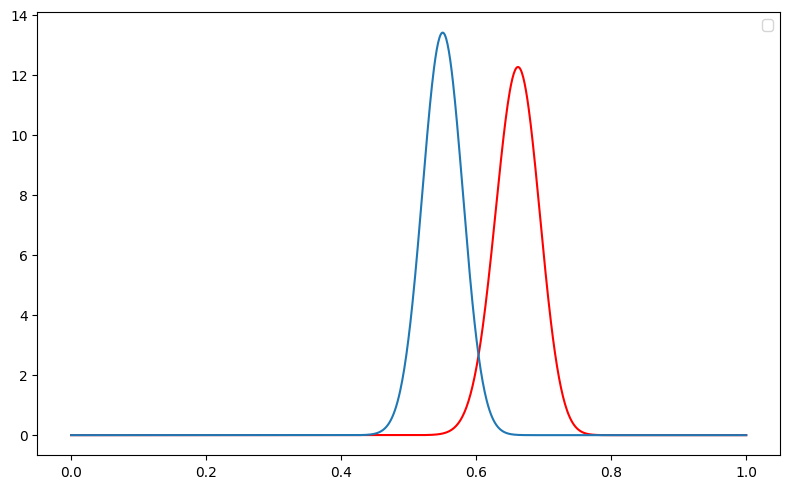

In [10]:
theta_vals = np.linspace(0, 1, 1000)

# Posterior for Model 1
post1 = beta.pdf(theta_vals, 140, 72)

# Posterior for Model 2
post2 = beta.pdf(theta_vals, 154, 126)

plt.figure(figsize=(8, 5))
plt.plot(theta_vals, post1,c='red')
plt.plot(theta_vals, post2)
plt.legend()
plt.tight_layout()
plt.show()


1.2

In [11]:
y = np.array([10, 15, 15, 14, 14, 14, 13, 11, 12, 16])
n = 20
num_samples = 5000

# Model 1
theta_samples_1 = beta.rvs(140, 72, size=num_samples)

# Model 2
theta_samples_2 = beta.rvs(154, 126, size=num_samples)

def compute_lppd(y, theta_samples):
    log_probs = []
    for yi in y:
        probs = binom.pmf(yi, n=n, p=theta_samples)
        avg_prob = np.mean(probs)
        log_probs.append(np.log(avg_prob))
    return np.sum(log_probs)


In [12]:
lppd_1 = compute_lppd(y, theta_samples_1)
lppd_2 = compute_lppd(y, theta_samples_2)

print(f"Model 1 LPPD: {lppd_1:.3f}")
print(f"Model 2 LPPD: {lppd_2:.3f}")

Model 1 LPPD: -20.364
Model 2 LPPD: -25.886


1.3

In [13]:
dev_1 = -2 * lppd_1
dev_2 = -2 * lppd_2
print(f"Model 1 in-sample deviance: {dev_1:.2f}")
print(f"Model 2 in-sample deviance: {dev_2:.2f}")

Model 1 in-sample deviance: 40.73
Model 2 in-sample deviance: 51.77


Because we are using the same data to fit the posterior (p(θ | y)), and evaluate predictive performance on y.

1.4

Model 1 is a better fit based on in-sample deviance — it's more consistent with the observed data and less surprised overall.

1.5

In [14]:
def compute_outsample_deviance(y_new, theta_samples):
    log_probs = []
    for yi in y_new:
        # predictive distribution p(y | θ) averaged over posterior samples
        probs = binom.pmf(yi, n=20, p=theta_samples)
        avg_prob = np.mean(probs)
        log_probs.append(np.log(avg_prob))
    lppd = np.sum(log_probs)
    dev = -2 * lppd
    return dev

new_y = [5, 6, 10, 8, 9]

dev_out_1 = compute_outsample_deviance(new_y, theta_samples_1)
dev_out_2 = compute_outsample_deviance(new_y, theta_samples_2)

print(f"Model 1 out-of-sample deviance: {dev_out_1:.2f}")
print(f"Model 2 out-of-sample deviance: {dev_out_2:.2f}")

Model 1 out-of-sample deviance: 50.67
Model 2 out-of-sample deviance: 31.56


Model 2 has lower out-of-sample deviance becuase its prior bias helped it generalize better to this low-y batch

1.6

In [15]:
y_all = np.array([10, 15, 15, 14, 14, 14, 13, 11, 12, 16])
n = 20
num_samples = 5000

def loo_lppd(y_all, a_prior, b_prior):
    loo_log_probs = []

    for i in range(len(y_all)):
        y_train = np.delete(y_all, i)
        sum_y_train = np.sum(y_train)

        # Posterior
        post_a = a_prior + sum_y_train
        post_b = b_prior + n * (len(y_train)) - sum_y_train

        theta_samples = beta.rvs(post_a, post_b, size=num_samples)

        # Predictive prob
        y_test = y_all[i]
        preds = binom.pmf(y_test, n=n, p=theta_samples)
        avg_pred = np.mean(preds)
        loo_log_probs.append(np.log(avg_pred))

    return np.sum(loo_log_probs)

# Model 1
loo_lppd_1 = loo_lppd(y_all, 6, 6)
dev_loo_1 = -2 * loo_lppd_1

# Model 2
loo_lppd_2 = loo_lppd(y_all, 20, 60)
dev_loo_2 = -2 * loo_lppd_2

print(f"Model 1 LOO deviance: {dev_loo_1:.2f}")
print(f"Model 2 LOO deviance: {dev_loo_2:.2f}")

Model 1 LOO deviance: 42.22
Model 2 LOO deviance: 54.44


# Part 2

In [17]:
import numpy as np
from math import comb
from scipy.special import gammaln
from scipy.stats import beta

2.1

In [18]:
def ml_binomial(k, n, a, b):
    log_ml = np.log(comb(n, k)) + \
             gammaln(k + a) + gammaln(n - k + b) - gammaln(n + a + b)
    return np.exp(log_ml)
k = 2
n = 10
priors = [
    (0.1, 0.4),
    (1, 1),
    (2, 6),
    (6, 2),
    (20, 60),
    (60, 20)
]

for a, b in priors:
    ml = ml_binomial(k, n, a, b)
    print(f"Beta({a},{b}) Marginal Likelihood: {ml:.5e}")


Beta(0.1,0.4) Marginal Likelihood: 4.73956e-01
Beta(1,1) Marginal Likelihood: 9.09091e-02
Beta(2,6) Marginal Likelihood: 4.72689e-03
Beta(6,2) Marginal Likelihood: 2.31386e-04
Beta(20,60) Marginal Likelihood: 5.07940e-21
Beta(60,20) Marginal Likelihood: 1.50663e-23


2.2

In [19]:
def monte_carlo_ml(k, n, a, b, num_samples=100_000):
    theta_samples = beta.rvs(a, b, size=num_samples)
    likelihoods = comb(n, k) * (theta_samples**k) * ((1 - theta_samples)**(n - k))
    return np.mean(likelihoods)
k, n = 2, 10
priors = [
    (0.1, 0.4),
    (1, 1),
    (2, 6),
    (6, 2),
    (20, 60),
    (60, 20)
]

for a, b in priors:
    ml_est = monte_carlo_ml(k, n, a, b)
    print(f"Beta({a},{b}) MC Marginal Likelihood: {ml_est:.5e}")


Beta(0.1,0.4) MC Marginal Likelihood: 3.99884e-02
Beta(1,1) MC Marginal Likelihood: 9.04295e-02
Beta(2,6) MC Marginal Likelihood: 1.98667e-01
Beta(6,2) MC Marginal Likelihood: 9.70755e-03
Beta(20,60) MC Marginal Likelihood: 2.69285e-01
Beta(60,20) MC Marginal Likelihood: 7.91592e-04
